<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [3]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [79]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

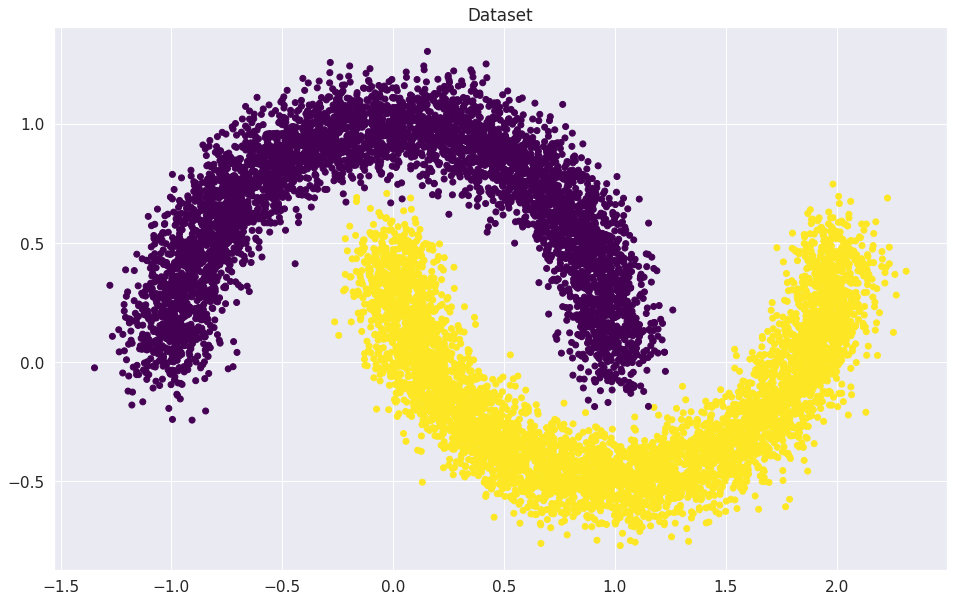

In [80]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [82]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train.reshape((-1, 1)))
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val.reshape((-1, 1)))

Создаем `Dataset` и `DataLoader`. 

In [83]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [103]:
class LinearRegression(nn.Module):
    def __init__(self,
                 in_features: int, 
                 out_features: int, 
                 bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn([in_features, out_features], requires_grad=True, dtype=torch.float))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn([1], requires_grad=True, dtype=torch.float))

    def forward(self, x):
        x =  x.matmul(self.weights)
        if self.bias:
            x += self.bias_term
        return x

In [104]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(linear_regression.parameters())
# optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.01)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [105]:
linear_regression.state_dict()

OrderedDict([('weights', tensor([[ 1.7653],
                      [-0.2365]])), ('bias_term', tensor([-1.2372]))])

**Ответ:** 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [106]:
X_batch, y_batch = next(iter(train_dataloader))
print(X_batch[:1])
print(linear_regression.weights)
logits = linear_regression(X_batch[:1])
print('logits: ', logits)

probabilities = 1/(1 + torch.exp(-logits))
print('probabilities:', probabilities)
# print(torch.sigmoid(outp))


loss = -torch.log(probabilities).mean()
print('loss: ', loss)

tensor([[ 0.5020, -0.3376]])
Parameter containing:
tensor([[ 1.7653],
        [-0.2365]], requires_grad=True)
logits:  tensor([[-0.2712]], grad_fn=<AddBackward0>)
probabilities: tensor([[0.4326]], grad_fn=<MulBackward0>)
loss:  tensor(0.8379, grad_fn=<NegBackward0>)


In [107]:
# linear_regression(X_batch)

In [108]:
# X_batch@linear_regression.weights + linear_regression.bias

In [109]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False


for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        logits = linear_regression(X_batch) # YOUR CODE. Use linear_regression to get outputs
        # YOUR CODE. Compute loss
        # loss = loss_function(y_batch, outp) 
        # loss  = torch.mean((y_batch-outp).pow(2))

        probabilities =  1/(1 + torch.exp(-logits)) # torch.sigmoid(outp)
        loss = -torch.log(probabilities).mean()
       
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()

        
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        
        if (it + epoch * len(train_dataloader)) % 10 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 64.34375
Iteration: 10
Batch accuracy: 67.1875
Iteration: 20
Batch accuracy: 64.140625
Iteration: 30
Batch accuracy: 64.703125
Iteration: 40
Batch accuracy: 63.90625
Iteration: 50
Batch accuracy: 63.453125
Iteration: 60
Batch accuracy: 64.75
Iteration: 70
Batch accuracy: 64.09375
Iteration: 80
Batch accuracy: 63.859375
Iteration: 90
Batch accuracy: 64.21875
Iteration: 100
Batch accuracy: 65.03125
Iteration: 110
Batch accuracy: 64.03125
Iteration: 120
Batch accuracy: 63.296875
Iteration: 130
Batch accuracy: 63.90625
Iteration: 140
Batch accuracy: 63.625
Iteration: 150
Batch accuracy: 64.5625
Iteration: 160
Batch accuracy: 61.125
Iteration: 170
Batch accuracy: 65.40625
Iteration: 180
Batch accuracy: 65.1875
Iteration: 190
Batch accuracy: 63.5625
Iteration: 200
Batch accuracy: 63.140625
Iteration: 210
Batch accuracy: 65.5625
Iteration: 220
Batch accuracy: 65.5625
Iteration: 230
Batch accuracy: 63.53125
Iteration: 240
Batch accuracy: 64.9375
Iteration: 250
Batc

**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 192

### Визуализируем результаты

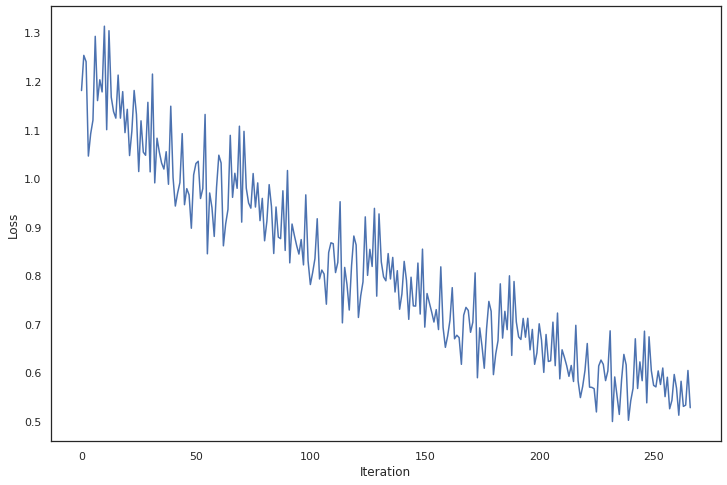

In [110]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

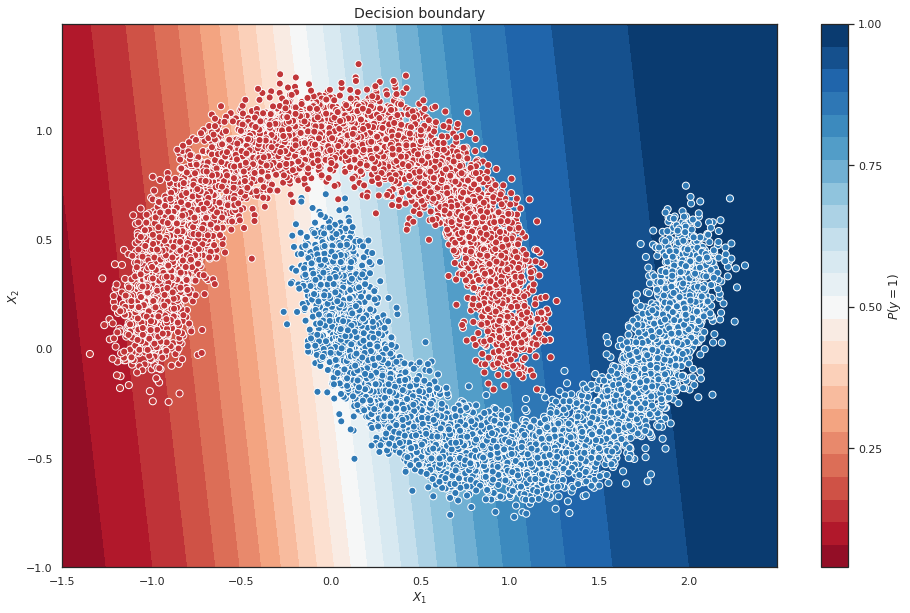

In [111]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25,
                      cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [112]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        logits = linear_regression(x_batch)
        probabilities = torch.sigmoid(logits)
        predictions = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [113]:
# X_batch_val, y_batch_val = next(iter(val_dataloader))
# print(X_batch_val[:1])

# logits = linear_regression(X_batch_val[:1])
# print(logits)

# probabilities = torch.sigmoid(logits)
# print(torch.sigmoid(logits))

# predictions = (probabilities > 0.5).type(torch.long)
# predictions

In [114]:
from sklearn.metrics import accuracy_score
acc = 0
batches = 0

for x_batch, y_batch in val_dataloader:
  # загружаем батч данных (вытянутый в линию)
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1)
  y_batch = y_batch

  W = linear_regression.weights
  preds = torch.argmax(x_batch @ W, dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')


Test accuracy 0.511


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.511

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [4]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader = DataLoader(val_dataset, batch_size=128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
X_batch, y_batch  = next(iter(train_dataloader))
X_batch.size()

torch.Size([128, 1, 28, 28])

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [6]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [7]:
activation = nn.ELU()
features = 28*28 # (784)
classes = 10

model = nn.Sequential(
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
    nn.Linear(features, 128),
    activation,
    nn.Linear(128, classes)   
)

In [8]:
from torchsummary import summary
summary(model, (features,), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 128]         100,480
               ELU-3                 [128, 128]               0
            Linear-4                  [128, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.03
Params size (MB): 0.39
Estimated Total Size (MB): 1.80
----------------------------------------------------------------


In [9]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [24]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = torch.sum(preds==y_batch) # YOUR CODE GOES HERE
            all =  preds.size()[0] # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward() 
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8882
Loader: valid. Accuracy: 0.9673
Epoch: 2
Loader: train. Accuracy: 0.96855
Loader: valid. Accuracy: 0.9767
Epoch: 3
Loader: train. Accuracy: 0.97785
Loader: valid. Accuracy: 0.9802
Epoch: 4
Loader: train. Accuracy: 0.9830666666666666
Loader: valid. Accuracy: 0.9849
Epoch: 5
Loader: train. Accuracy: 0.98635
Loader: valid. Accuracy: 0.9857
Epoch: 6
Loader: train. Accuracy: 0.9893166666666666
Loader: valid. Accuracy: 0.9878
Epoch: 7
Loader: train. Accuracy: 0.9909166666666667
Loader: valid. Accuracy: 0.988
Epoch: 8
Loader: train. Accuracy: 0.9923833333333333
Loader: valid. Accuracy: 0.9862
Epoch: 9
Loader: train. Accuracy: 0.9935333333333334
Loader: valid. Accuracy: 0.9838
Epoch: 10
Loader: train. Accuracy: 0.9948166666666667
Loader: valid. Accuracy: 0.9858


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [25]:
elu_accuracy = accuracy["valid"]

In [26]:
# YOUR CODE. Do the same thing with other activations 
# (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    #YOUR CODE

    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    features = 28*28 # (784)
    classes = 10

    model = nn.Sequential(
        nn.Flatten(),
        #YOUR CODE. Add layers to your sequential class
        nn.Linear(features, 128),
        activation(),
        nn.Linear(128, classes)   
    )
    criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    model.eval()
                    outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = torch.sum(preds==y_batch) # YOUR CODE GOES HERE
                all =  preds.size()[0] # YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
                    loss.backward() 
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]


In [27]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.86735
Loader: valid. Accuracy: 0.9018
Epoch: 2
Loader: train. Accuracy: 0.8999666666666667
Loader: valid. Accuracy: 0.9046
Epoch: 3
Loader: train. Accuracy: 0.9053166666666667
Loader: valid. Accuracy: 0.9054
Epoch: 4
Loader: train. Accuracy: 0.9075166666666666
Loader: valid. Accuracy: 0.9069
Epoch: 5
Loader: train. Accuracy: 0.9085
Loader: valid. Accuracy: 0.9078
Epoch: 6
Loader: train. Accuracy: 0.9099666666666667
Loader: valid. Accuracy: 0.9088
Epoch: 7
Loader: train. Accuracy: 0.9111666666666667
Loader: valid. Accuracy: 0.9087
Epoch: 8
Loader: train. Accuracy: 0.9117333333333333
Loader: valid. Accuracy: 0.9092
Epoch: 9
Loader: train. Accuracy: 0.9126333333333333
Loader: valid. Accuracy: 0.9091
Epoch: 10
Loader: train. Accuracy: 0.9134333333333333
Loader: valid. Accuracy: 0.9096
Epoch: 1
Loader: train. Accuracy: 0.8691
Loader: valid. Accuracy: 0.9158
Epoch: 2
Loader: train. Accuracy: 0.9234833333333333
Loader: valid. Accuracy: 0.9386
Epoch: 3
Loade

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

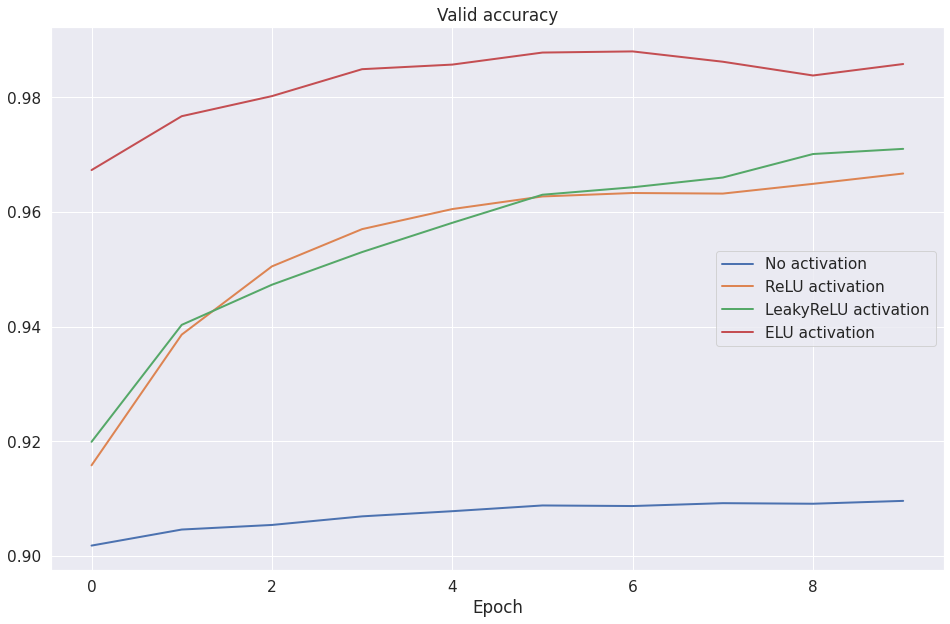

In [28]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** LeakyReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [11]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-08-01 19:41:09--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-08-01 19:41:11--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  90.6KB/s    in 0.5s    

2022-08-01 19:41:12 (90.6 KB/s) - ‘sample_photo.jpg’ saved [49337/

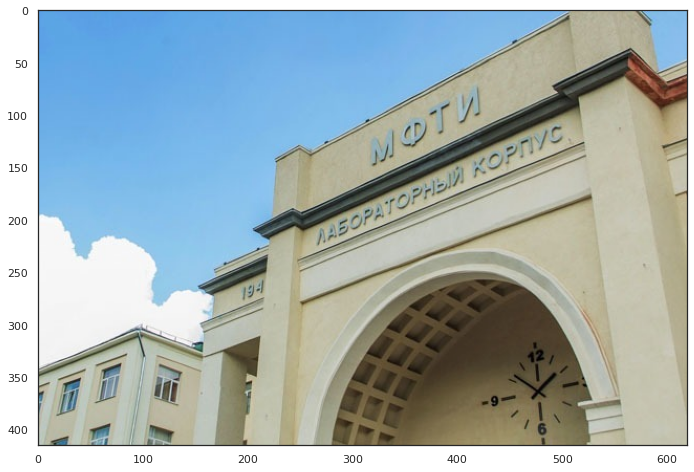

In [12]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [13]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
   [0, 0, 0],
[1, 1, 1],
[0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


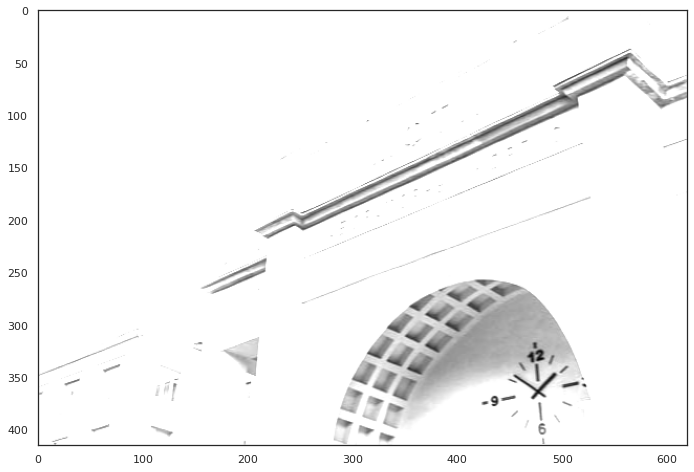

In [14]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [15]:
import torch.nn.functional as F

In [31]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2) #YOUR CODE
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3) #YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size=2) #YOUR CODE
        self.fc1 = nn.Linear(5*5*16, 120)#YOUR CODE  
        self.fc2 = nn.Linear(120, 84)#YOUR CODE
        self.fc3 = nn.Linear(84, 10)#YOUR CODE

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) #YOUR CODE. Apply layers created in __init__. 
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5*5*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # print(x.shape)
        return x

In [32]:
model = LeNet().to(device)

In [33]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [35]:
# <YOUR CODE>
num_epochs = 10
tol = 1e-3
accuracies = {'train': [], 'valid': []}

for epoch in range(num_epochs):
    epoch_cor = 0
    epoch_all = 0
    for k, dataloader in loaders.items():
        for X_batch, y_batch in dataloader:
            if k == 'train':
                model.train()
                optimizer.zero_grad()
                outp = model(X_batch)
            else:
                model.eval()
                outp = model(X_batch)

            preds = outp.argmax(-1)
            num_cor = torch.sum(preds == y_batch)
            num_all = preds.size()[0]

            epoch_cor += num_cor.item()
            epoch_all += num_all

            if k == 'train':
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()

        if k == 'train':
          print(f'Epoch: {epoch+1}')
        acc = epoch_cor/epoch_all
        print(f'Loader: {k}. Accuracy: {acc}')
        accuracies[k].append(acc)


Epoch: 1
Loader: train. Accuracy: 0.8869
Loader: valid. Accuracy: 0.8978
Epoch: 2
Loader: train. Accuracy: 0.96665
Loader: valid. Accuracy: 0.9675
Epoch: 3
Loader: train. Accuracy: 0.97725
Loader: valid. Accuracy: 0.9775285714285714
Epoch: 4
Loader: train. Accuracy: 0.9830833333333333
Loader: valid. Accuracy: 0.9828571428571429
Epoch: 5
Loader: train. Accuracy: 0.9865333333333334
Loader: valid. Accuracy: 0.9862285714285715
Epoch: 6
Loader: train. Accuracy: 0.9886666666666667
Loader: valid. Accuracy: 0.9882857142857143
Epoch: 7
Loader: train. Accuracy: 0.99055
Loader: valid. Accuracy: 0.9898857142857143
Epoch: 8
Loader: train. Accuracy: 0.9925166666666667
Loader: valid. Accuracy: 0.9917714285714285
Epoch: 9
Loader: train. Accuracy: 0.9937833333333334
Loader: valid. Accuracy: 0.9927857142857143
Epoch: 10
Loader: train. Accuracy: 0.9947666666666667
Loader: valid. Accuracy: 0.9932142857142857


In [36]:
lenet_accuracy = accuracies["valid"]

Сравним с предыдущем пунктом

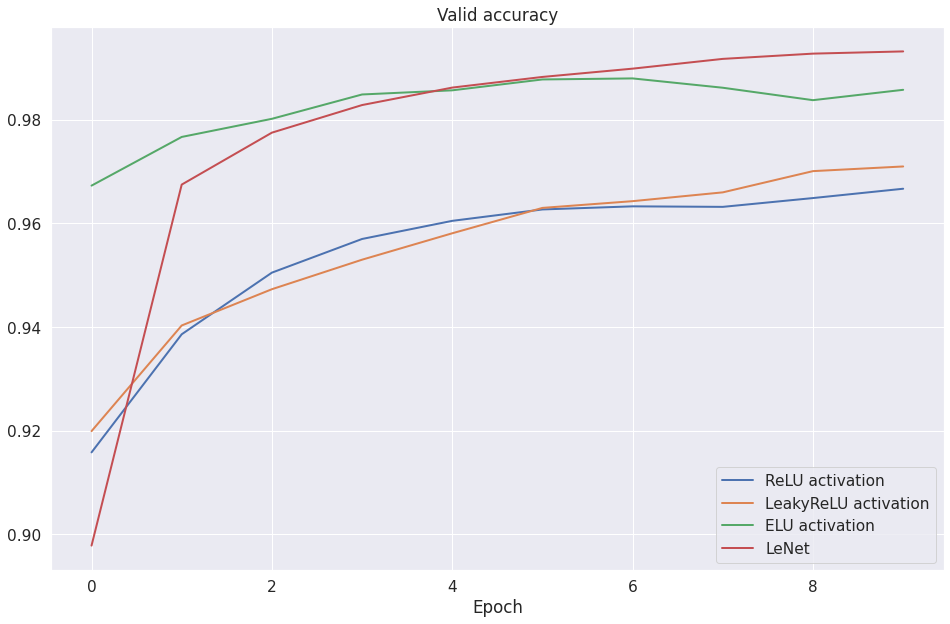

In [37]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.9932